In [131]:
import os
import json
import random
import csv
import re
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
import numpy as np
from bisect import bisect_left
import pandas as pd
import math
import networkx as nx
from sankeyflow import Sankey
import textwrap

filePath = "./files/"


def get_valid_filename(name):
    s = str(name).strip().replace(" ", "_")
    s = re.sub(r"(?u)[^-\w.]", "", s)
    if s in {"", ".", ".."}:
        return "ErrorFileName" + str(random.randrange(100000))
    return s


def get_valid_path(path):
    s = str(path).strip().replace(" ", "_")
    s = re.sub(r"(?u)[^-\w./]", "", s)
    if s in {"", ".", ".."}:
        return "ErrorFileName" + str(random.randrange(100000))
    return s


def loadJSON(fullFileName):
    if not os.path.exists(fullFileName):
        return {}
    with open(fullFileName, "r") as inputFile:
        data = json.load(inputFile)
    return data


def dumpFile(fileName, data, path=filePath):
    fullFileName = get_valid_path(path) + get_valid_filename(fileName) + ".bin"
    os.makedirs(os.path.dirname(fullFileName), exist_ok=True)
    with open(fullFileName, "wb") as outputFile:
        pickle.dump(data, outputFile)
    return fullFileName


def checkForFile(filename):
    return os.path.exists(filePath + get_valid_filename(filename) + ".bin")


def loadFile(fileName):
    fullFileName = filePath + get_valid_filename(fileName) + ".bin"
    if not os.path.exists(fullFileName):
        return {}
    with open(fullFileName, "rb") as inputFile:
        data = pickle.load(inputFile)
    return data


def saveOrLoadFile(fileName, fileFunction, functionParams={}):
    if checkForFile(fileName):
        return loadFile(fileName)
    else:
        fileData = fileFunction(**functionParams)
        dumpFile(fileName, fileData)
        return fileData


In [2]:
def generateSimplifiedData():
    dataFiles = []

    dirpath = "./data"
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            dataFiles.append(os.path.join(root, name))

    data = []
    for dataFile in dataFiles:
        data.extend(loadJSON(dataFile))

    simplifiedData = [
        {
            "Source": d.get("from"),
            "Target": d.get("to") if d.get("to") != "" else d.get("contractAddress"),
            "Timeset": datetime.fromtimestamp(int(d.get("timeStamp"))).isoformat(),
            "Weight": int(d.get("value") if d.get("value") is not None else 0) + 1,
            "Contract": d.get("contractAddress"),
        }
        for d in data
    ]

    return simplifiedData


simplifiedData = saveOrLoadFile(
    fileName="simplifiedData", fileFunction=generateSimplifiedData
)


In [39]:
def filterSimplifiedData(
    data, minTime=None, maxTime=None, minWeight=None, maxWeight=None, contract=None
):
    filteredData = filter(
        lambda dataPoint: (
            (minTime is None or datetime.fromisoformat(dataPoint["Timeset"]) >= minTime)
            and (maxTime is None or datetime.fromisoformat(dataPoint["Timeset"]) <= maxTime)
            and (minWeight is None or dataPoint["Weight"] >= minWeight)
            and (maxWeight is None or dataPoint["Weight"] <= maxWeight)
            and (contract is None or dataPoint["Contract"] == contract)
        ),
        data,
    )

    return list(filteredData)


In [4]:
# def makeGraphFile(data):
#     keys = data[0].keys()
#     fileName = "SANDgraph" +".csv"
#     with open(fileName, 'w', newline='') as output_file:
#         dict_writer = csv.DictWriter(output_file, keys)
#         dict_writer.writeheader()
#         dict_writer.writerows(data)

# makeGraphFile(random.sample(simplifiedData, 400000))


In [5]:
def generateDataGraph(simplifiedData):
    dataGraph = nx.MultiDiGraph()
    for simplifiedDataPoint in simplifiedData:
        dataGraph.add_edge(
            simplifiedDataPoint["Source"],
            simplifiedDataPoint["Target"]
            if simplifiedDataPoint["Target"] != ""
            else simplifiedDataPoint["Contract"],
            key=simplifiedDataPoint["Timeset"],
            attr={
                "Timeset": simplifiedDataPoint["Timeset"],
                "Weight": simplifiedDataPoint["Weight"],
                "Contract": simplifiedDataPoint["Contract"],
            },
        )
    return dataGraph


dataGraph = saveOrLoadFile("graphData", generateDataGraph, {"simplifiedData": simplifiedData})


In [6]:
# def getSandValueData():
#     with open("sandboxValueData.csv", "r") as inputFile:
#         sandValueData = csv.DictReader(inputFile)
#         sandValueData = [{d["\ufeffStart"]: d["Market Cap"]} for d in sandValueData]
#     return sandValueData

# sandValueData = saveOrLoadFile("sandValueData", getSandValueData)
# print(len(sandValueData))


In [7]:
# Source: https://github.com/jeroenvldj/bow-tie_detection/tree/master


def get_bowtie_components(graph):
    """Classifying the nodes of a network into a bow-tie structure.
    Here we follow the definition of a bow-tie as in:
    "Bow-tie Decomposition in Directed Graphs" - Yang et al. IEEE (2011)

    input:  NetworkX directed graph or numpy adjacency matrix
    output: sets of nodes in the specified partitions (following the
            NetworkX input graph node labelling or labelled according to
            the order of the adjacency matrix [0, n-1])
    """

    # Verify graph input format
    input_formats = [nx.DiGraph, nx.MultiDiGraph, np.ndarray, np.matrix]
    assert (
        type(graph) in input_formats
    ), "Input should be a NetworkX directed graph or numpy adjacency matrix"
    if (
        type(graph) == nx.classes.digraph.DiGraph
        or type(graph) == nx.classes.multidigraph.MultiDiGraph
    ):
        G = graph.copy()
    if (type(graph) == np.ndarray) or (type(graph) == np.matrix):
        G = nx.from_numpy_matrix(np.matrix(graph), create_using=nx.DiGraph())

    GT = nx.reverse(G, copy=True)

    strongly_con_comp = list(nx.strongly_connected_components(G))
    strongly_con_comp = max(strongly_con_comp, key=len)

    S = strongly_con_comp

    v_any = list(S)[0]
    DFS_G = set(nx.dfs_tree(G, v_any).nodes())
    DFS_GT = set(nx.dfs_tree(GT, v_any).nodes())
    OUT = DFS_G - S
    IN = DFS_GT - S
    V_rest = set(G.nodes()) - S - OUT - IN

    TUBES = set()
    INTENDRILS = set()
    OUTTENDRILS = set()
    OTHER = set()
    for v in V_rest:
        irv = len(IN & set(nx.dfs_tree(GT, v).nodes())) != 0
        vro = len(OUT & set(nx.dfs_tree(G, v).nodes())) != 0
        if irv and vro:
            TUBES.add(v)
        elif irv and not vro:
            INTENDRILS.add(v)
        elif not irv and vro:
            OUTTENDRILS.add(v)
        elif not irv and not vro:
            OTHER.add(v)

    return S, IN, OUT, TUBES, INTENDRILS, OUTTENDRILS, OTHER


In [8]:
SCC, IN, OUT, TUBES, INTENDRILS, OUTTENDRILS, OTHER = saveOrLoadFile(
    "bowtieComponents", get_bowtie_components, {"graph": dataGraph}
)


In [9]:
def netToSimp(network, data):
    data = sorted(
        data,
        key=lambda dataPoint: str(dataPoint["Source"])
        + str(dataPoint["Target"])
        + str(dataPoint["Timeset"])
        + str(dataPoint["Weight"])
        + str(dataPoint["Contract"]),
    )
    edges = sorted(
        list(network.edges(data=True)),
        key=lambda edge: str(edge[0])
        + str(edge[1])
        + str(edge[2]["attr"]["Timeset"])
        + str(edge[2]["attr"]["Weight"])
        + str(edge[2]["attr"]["Contract"]),
    )
    selectedData = [[]] * len(edges)
    # print(len(edges))
    i = 0
    for dataPoint in data:
        if (
            edges[i][0] == dataPoint["Source"]
            and edges[i][1] == dataPoint["Target"]
            and edges[i][2]["attr"]["Timeset"] == dataPoint["Timeset"]
            and edges[i][2]["attr"]["Weight"] == dataPoint["Weight"]
            and edges[i][2]["attr"]["Contract"] == dataPoint["Contract"]
        ):
            selectedData[i] = dataPoint
            i += 1
    return selectedData


def filterByNodes(nodes, data, attrs, combine=False):
    filteredData = data
    operator = any if combine else all
    filteredData = filter(lambda dataPoint: operator([dataPoint[attr] in nodes for attr in attrs]), filteredData)
    return list(filteredData)


In [10]:
# def getTimeData(data, attribute=None):
#     timeData = {}

#     def checkAndAdd(key, addValue=1):
#         if key not in timeData:
#             timeData[key] = 0
#         timeData[key] += addValue

#     for dataPoint in data:
#         checkAndAdd(
#             datetime.date(datetime.fromisoformat(dataPoint["Timeset"])),
#             1 if attribute is None else dataPoint[attribute],
#         )

#     return dict(sorted(timeData.items()))

def getTimeData(data, attribute=None):
    if len(data) == 0:
        return {}
    lastDate = datetime.date(
        datetime.fromisoformat(
            max(data, key=lambda dataPoint: dataPoint["Timeset"])["Timeset"]
        )
    )
    firstDate = datetime.date(
        datetime.fromisoformat(
            min(data, key=lambda dataPoint: dataPoint["Timeset"])["Timeset"]
        )
    )

    timeData = {date.date(): 0 for date in pd.date_range(firstDate, lastDate)}

    for dataPoint in data:
        timeData[datetime.date(datetime.fromisoformat(dataPoint["Timeset"]))] += (
            1 if attribute is None else dataPoint[attribute]
        )

    return dict(sorted(timeData.items()))


In [11]:
defaultTickMultiplier = 2 / 3
defaultFigsize = (15, 5)
defaultDpi = 150
defaultTitle = "Number of Transactions vs Date"
defaultYLabel = "Number of Transactions"
defaultXLabel = "Date"
graphFolder = "./graphs/"
graphFileType = ".png"


def plotDateRange(
    datas,
    start=None,
    end=None,
    tickMultiplier=defaultTickMultiplier,
    specialDates={},
    figsize=defaultFigsize,
    dpi=defaultDpi,
    title=defaultTitle,
    xlabel=defaultXLabel,
    ylabel=defaultYLabel,
    graphAttributes=[],
):
    def calcXticksAndLabels():
        graphWidth = figsize[0]
        previousDate = keysToUse[0]
        totalTimeDelta = keysToUse[-1] - previousDate
        specailDatesAndEnd = sorted(specialDates.keys())
        specailDatesAndEnd.append(keysToUse[-1])
        for specialDate in specailDatesAndEnd:
            timeDelta = specialDate - previousDate
            xticks.extend(
                list(
                    pd.date_range(
                        previousDate,
                        specialDate,
                        math.floor(
                            tickMultiplier * graphWidth * (timeDelta / totalTimeDelta)
                        ),
                    )
                )
            )
            xticks.append(specialDate)
            previousDate = specialDate

        for xtick in xticks:
            if type(xtick) != type(datetime.now().date()):
                xtick = xtick.date()
            if xtick in specialDates and specialDates[xtick] is not None:
                xtickLabels.append(specialDates[xtick] + "\n" + str(xtick))
            else:
                xtickLabels.append(xtick)

        return xticks, xtickLabels

    def plot(keysToUseList, valuesToUseList, legend=None):
        attributesString = ""
        if len(graphAttributes) > 0:
            attributesString = " ("
            attributesString += graphAttributes[0]
            for graphAttribute in graphAttributes[1:]:
                attributesString += ", " + graphAttribute
            attributesString += ")"

        plt.figure(figsize=figsize, dpi=dpi)
        for i in range(len(keysToUseList)):
            plt.plot(keysToUseList[i], valuesToUseList[i])
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title + attributesString)
        plt.xticks(xticks, xtickLabels)
        if legend is not None:
            plt.legend(legend, title="Nodes Included")
        plt.savefig(
            fname=graphFolder + title + attributesString + graphFileType,
            bbox_inches="tight",
        )
        plt.close()

    keysToUseList = []
    valuesToUseList = []
    xtickLabels = []
    xticks = []
    legend = []
    graphAttributes.append("Placeholder")
    for filterName, filteredData in datas.items():
        keyslist = list(filteredData.keys())
        startIndex = bisect_left(keyslist, start) if start is not None else 0
        endIndex = bisect_left(keyslist, end) if end is not None else len(keyslist)

        keysToUse = keyslist[startIndex:endIndex]

        if xticks == []:
            xticks, xtickLabels = calcXticksAndLabels()

        valueslist = list(filteredData.values())
        valuesToUse = valueslist[startIndex:endIndex]
        graphAttributes[-1] = filterName + " Nodes"
        # print(valuesToUse)
        plot([keysToUse], [valuesToUse])
        valuesToUseList.append(valuesToUse)
        keysToUseList.append(keysToUse)
        legend.append(filterName)

    graphAttributes = graphAttributes[:-1]
    plot(keysToUseList, valuesToUseList, legend)


def plotAroundDate(center, startDist=30, endDist=None, **plotParams):
    endDist = startDist if endDist is None else endDist
    plotParams["start"] = center - timedelta(startDist)
    plotParams["end"] = center + timedelta(endDist)
    plotDateRange(**plotParams)


In [12]:
def plotData(data, events, filters, attributes, zooms, titleAddition=""):
    timeDatas = {}
    for filterName, filterNodes, filterAttributes in filters:
        # print(filterAttributes)
        filteredData = filterByNodes(filterNodes, data, filterAttributes)
        for attributeName, attribute in attributes:
            if attributeName not in timeDatas:
                timeDatas[attributeName] = {}
            timeDatas[attributeName][filterName] = getTimeData(filteredData, attribute)

    for attributeName, filteredDatas in timeDatas.items():
        for eventDate, eventName in events.items():
            graphAttributes = [str(eventDate), "Weighted by " + attributeName]
            eventNameSingleLine = eventName.replace("\n", "")
            for zoom in zooms:
                plotAroundDate(
                    center=eventDate,
                    startDist=zoom,
                    endDist=zoom,
                    datas=filteredDatas,
                    specialDates={eventDate: eventName},
                    ylabel=attributeName,
                    title=str(zoom)
                    + " Day Zoom of the "
                    + "Effect of "
                    + eventNameSingleLine
                    + titleAddition,
                    graphAttributes=graphAttributes,
                )
        plotDateRange(
            filteredDatas,
            specialDates=events,
            figsize=(200, 10),
            ylabel=attributeName,
            graphAttributes=graphAttributes,
            title=defaultTitle + titleAddition
        )


In [13]:
events = {
    datetime(2021, 5, 3).date(): "ZEPETO",
    datetime(2022, 9, 9).date(): "Atari",
    datetime(2022, 11, 11).date(): "Care Bears",
    datetime(2020, 10, 29).date(): "The Smurfs",
    datetime(2022, 7, 19).date(): "Steve Aoki",
    datetime(2021, 10, 29).date(): "deadmau5",
    datetime(2021, 12, 15).date(): "Adidas",
    datetime(2021, 9, 23).date(): "Snoop Dogg",
    datetime(2021, 7, 8).date(): "The Walking Dead",
    datetime(2022, 10, 28).date(): "Gucci Vault",
    datetime(2022, 2, 8).date(): "Ubisoft",
    datetime(2022, 1, 27).date(): "Warner Music Group",
    datetime(2022, 2, 28).date(): "Square Enix",
    datetime(2023, 5, 26).date(): "CEO's Twitter \nHacked",
    datetime(2023, 2, 26).date(): "Computer Hacked to \nSend Phishing Emails",
    datetime(2023, 6, 6).date(): "SEC Naming \nSAND as Unregistered \nSecurity",
    datetime(2022, 3, 23).date(): "Ronin Hack",
    # datetime(2023, 1, 18).date(): "Lunar New Year Event",
}

filters = [
    ("ALL", {}, []),
    ("IN", IN, ["Source"]),
    ("OUT", OUT, ["Target"]),
    ("SCC", SCC, ["Source", "Target"]),
]

attributes = [
    ("Number of Transactions", None),
    ("Value of Transactions", "Weight"),
]

zooms = [30, 90]


In [14]:
print("Number of Transactions: " + str(len(simplifiedData)))
print("Number of Addresses: " + str(len(set([d["Source"] for d in simplifiedData] + [d["Target"] for d in simplifiedData]))))


Number of Transactions: 4948956
Number of Addresses: 659248


In [14]:
plotData(simplifiedData, events, filters, attributes, zooms)


In [17]:
def getWhales(data, minValue=1e22, numberOfWhales=-1):
    def checkAndAdd(address, value):
        if address not in addresses:
            addresses[address] = 0
        addresses[address] += value
    def checkAndSupplant(address):
        if address not in maxAddresses:
            maxAddresses[address] = addresses[address]
        elif maxAddresses[address] < addresses[address]:
            maxAddresses[address] = addresses[address]


    addresses = {}
    maxAddresses = {}
    for dataPoint in data:
        checkAndAdd(dataPoint["Source"], -dataPoint["Weight"])
        checkAndAdd(dataPoint["Target"], dataPoint["Weight"])
        checkAndSupplant(dataPoint["Source"])
        checkAndSupplant(dataPoint["Target"])

    whales = set(
        [
            whale
            for whale, value in sorted(
                filter(lambda address: address[1] > minValue, addresses.items()),
                key=lambda address: address[1],
                reverse=True,
            )[:numberOfWhales]
        ]
    )

    maxWhales = set(
        [
            whale
            for whale, value in sorted(
                filter(lambda address: address[1] > minValue, maxAddresses.items()),
                key=lambda address: address[1],
                reverse=True,
            )[:numberOfWhales]
        ]
    )

    return whales, maxWhales


In [18]:
whales, maxWhales = getWhales(filterSimplifiedData(simplifiedData, contract="0x3845badade8e6dff049820680d1f14bd3903a5d0"))


In [17]:
print("Current Whales: " + str(len(whales)) + "\nAll Whales Over Time: " + str(len(maxWhales)))
print("Current Whales in SCC: " + str(sum([whale in SCC for whale in whales])) + "\nAll Whales Over Time in SCC: " + str(sum([whale in SCC for whale in maxWhales])))
print("Current Whales in OUT: " + str(sum([whale in OUT for whale in whales])) + "\nAll Whales Over Time in OUT: " + str(sum([whale in OUT for whale in maxWhales])))


Current Whales: 2464
All Whales Over Time: 33758
Current Whales in SCC: 890
All Whales Over Time in SCC: 32174
Current Whales in OUT: 1574
All Whales Over Time in OUT: 1584


In [18]:
plotData(filterByNodes(whales, simplifiedData, ["Source", "Target"], combine=True), events, filters, attributes, zooms, titleAddition=" On Current Whales")


In [19]:
plotData(filterByNodes(whales, simplifiedData, ["Target"], combine=True), events, filters, attributes, zooms, titleAddition=" On Current Whales Investing More")


In [20]:
plotData(filterByNodes(whales, simplifiedData, ["Source"], combine=True), events, filters, attributes, zooms, titleAddition=" On Current Whales Investing Less")


In [21]:
plotData(filterByNodes(maxWhales, simplifiedData, ["Source", "Target"], combine=True), events, filters, attributes, zooms, titleAddition=" On All Whales Over Time")


In [22]:
plotData(filterByNodes(maxWhales, simplifiedData, ["Target"], combine=True), events, filters, attributes, zooms, titleAddition=" On All Whales Over Time Investing More")


In [23]:
plotData(filterByNodes(maxWhales, simplifiedData, ["Source"], combine=True), events, filters, attributes, zooms, titleAddition=" On All Whales Over Time Investing Less")


: 

In [19]:
def anonymoizeDates(data, center, startDist, endDist):
    numbers = list(range(-startDist, endDist+1))
    datas = [0] * len(numbers)
    for dif in numbers:
        date = center + timedelta(dif)
        if date in data:
            datas[dif + startDist] = data[date]
    return numbers, datas


In [217]:
defaultFigsize = (24, 8)
defaultDpi = 150
defaultTitle = "Number of Transactions vs Date"
defaultYLabel = "Number of Transactions"
defaultXLabel = "Date"
defaultLegendTitle = "Events"
defaultStartBuffer = 30


def plotDatas(
    data,
    startBuffer=defaultStartBuffer,
    endBuffer=None,
    events={},
    figsize=defaultFigsize,
    dpi=defaultDpi,
    title=defaultTitle,
    xlabel=defaultXLabel,
    ylabel=defaultYLabel,
    legendTitle=defaultLegendTitle,
    subFolder=""
):
    endBuffer = startBuffer if endBuffer is None else endBuffer
    if len(events) <= 5:
        figsize = (figsize[0], figsize[1]/2)
    plt.figure(figsize=figsize, dpi=dpi)
    i = 0
    for eventDate in events.keys():
        numbers, datas = anonymoizeDates(data, eventDate, startBuffer, endBuffer)
        if(i > 9):
            plt.plot(numbers, datas, "--")
        else:
            plt.plot(numbers, datas)
        i += 1
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title, fontsize=30)
    plt.legend([name + " (" + str(date) + ")" for date, name in events.items()], title=legendTitle)
    plt.xticks(numbers)
    plt.savefig(
        fname=graphFolder + subFolder + title + graphFileType,
        bbox_inches="tight",
    )
    plt.close()


In [218]:
condensedGraphFolder = "condensedGraphs/"


def plotCondensedGraphs(data, events, attributes, titleAddition="", titlePrefix=""):
    for attributeName, attribute in attributes:
        timeData = getTimeData(data, attribute)
        plotDatas(
            timeData,
            events=events,
            title=titlePrefix + attributeName + " vs " + defaultXLabel + titleAddition,
            subFolder=condensedGraphFolder,
            ylabel=attributeName,
        )


In [219]:
supportEvents = {
    datetime(2021, 5, 3).date(): "ZEPETO",
    datetime(2022, 9, 9).date(): "Atari",
    datetime(2022, 11, 11).date(): "Care Bears",
    datetime(2020, 10, 29).date(): "The Smurfs",
    datetime(2022, 7, 19).date(): "Steve Aoki",
    datetime(2021, 10, 29).date(): "deadmau5",
    datetime(2021, 12, 15).date(): "Adidas",
    datetime(2021, 9, 23).date(): "Snoop Dogg",
    datetime(2021, 7, 8).date(): "The Walking Dead",
    datetime(2022, 10, 28).date(): "Gucci Vault",
    datetime(2022, 2, 8).date(): "Ubisoft",
    datetime(2022, 1, 27).date(): "Warner Music Group",
    datetime(2022, 2, 28).date(): "Square Enix",
}

scandals = {
    datetime(2023, 5, 26).date(): "CEO's Twitter \nHacked",
    datetime(2023, 2, 26).date(): "Computer Hacked to \nSend Phishing Emails",
    datetime(2023, 6, 6).date(): "SEC Naming \nSAND as Unregistered \nSecurity",
    datetime(2022, 3, 23).date(): "Ronin Hack",
}

filters = [
    ("ALL", {}, []),
    ("IN", IN, ["Source"]),
    ("OUT", OUT, ["Target"]),
    ("SCC", SCC, ["Source", "Target"]),
]

attributes = [
    ("Number of Transactions", None),
    ("Value of Transactions", "Weight"),
]


In [220]:
plotCondensedGraphs(simplifiedData, supportEvents, attributes, titlePrefix="Effect of Support Events on ")
plotCondensedGraphs(simplifiedData, scandals, attributes, titlePrefix="Effect of Scandals on ")



In [221]:
plotCondensedGraphs(filterByNodes(whales, simplifiedData, ["Source", "Target"], combine=True), events, attributes, titlePrefix="Effect of Events on ", titleAddition=" On Current Whales")


In [222]:
plotCondensedGraphs(filterByNodes(whales, simplifiedData, ["Source", "Target"], combine=True), supportEvents, attributes, titlePrefix="Effect of Support Events on ", titleAddition=" On Current Whales")
plotCondensedGraphs(filterByNodes(whales, simplifiedData, ["Source", "Target"], combine=True), scandals, attributes, titlePrefix="Effect of Scandals on ", titleAddition=" On Current Whales")


In [223]:
plotCondensedGraphs(filterByNodes(maxWhales, simplifiedData, ["Source", "Target"], combine=True), supportEvents, attributes, titlePrefix="Effect of Support Events on ", titleAddition=" On All Whales Over Time")
plotCondensedGraphs(filterByNodes(maxWhales, simplifiedData, ["Source", "Target"], combine=True), scandals, attributes, titlePrefix="Effect of Scandals on ", titleAddition=" On All Whales Over Time")


In [23]:
selectedEvents = [
    (datetime(2022, 2, 28).date(), "Square Enix"),
    (datetime(2021, 10, 29).date(), "deadmau5"),
    (datetime(2022, 1, 27).date(), "Warner Music Group"),
    (datetime(2023, 5, 26).date(), "CEO's Twitter Hacked"),
    (datetime(2023, 6, 6).date(), "SEC Naming SAND as Unregistered Security"),
    (datetime(2022, 3, 23).date(), "Ronin Hack"),
]

filters = [
    ("SCC", SCC, ["Source", "Target"], False),
    ("OUT", OUT, ["Target"], False),
    ("IN", IN, ["Source"], False),
    # ("TUBES", TUBES, ["Source", "Target"], True),
    # ("IN TENDRILS", INTENDRILS, ["Target"], False),
    # ("OUT TENDRILS", OUTTENDRILS, ["Source"], False),
    # ("OTHER", OTHER, ["Source", "Target"], True),
]

attributes = [
    ("Number of Transactions", None),
    # ("Value of Transactions", "Weight"),
]


In [24]:
def getLimitedDates(data, center, startDist, endDist):
    dates = list(pd.date_range(center - timedelta(startDist), center + timedelta(endDist)))
    values = [0] * len(dates)
    for i in range(len(dates)):
        values[i] = data[dates[i].date()]
    return dates, values


In [25]:
defaultFigsize = (15,5)
defaultDpi = 150
defaultTitle = "Number of Transactions vs Date"
defaultYLabel = "Number of Transactions"
defaultXLabel = "Date"
defaultLegendTitle = "Bow-Tie Groups"
defaultStartBuffer = 30
defaultSubFolder = "stackedBars/"

def plotStackedBar(
    data,
    filters,
    event,
    attribute,
    startBuffer=defaultStartBuffer,
    endBuffer=None,
    figsize=defaultFigsize,
    dpi=defaultDpi,
    title=defaultTitle,
    xlabel=defaultXLabel,
    ylabel=defaultYLabel,
    legendTitle=defaultLegendTitle,
    subFolder=defaultSubFolder
):
    endBuffer = startBuffer if endBuffer is None else endBuffer
    eventDate = event[0]
    eventName = event[1]

    plt.figure(figsize=figsize, dpi=dpi)
    bottom = np.zeros(startBuffer + endBuffer + 1, dtype=object)
    for name, nodes, options, combine in filters:
        numbers, datas = getLimitedDates(getTimeData(filterByNodes(nodes, data, options, combine), attribute), eventDate, startBuffer, endBuffer)
        plt.bar(numbers, datas, width=0.5, bottom=bottom, label=name)
        # print(np.array(datas))
        bottom += np.array(datas)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    xticks = numbers[::math.floor(figsize[0]/3)]
    xticks.append(eventDate)
    plt.xticks(xticks)
    plt.legend(title=legendTitle)
    plt.savefig(
        fname=graphFolder + subFolder + title + graphFileType,
        bbox_inches="tight",
    )
    plt.close()


In [26]:
def plotStackedBars(
    data, events, filters, attributes, titleAddition="", titlePrefix=""
):
    for event in events:
        for attributeName, attribute in attributes:
            plotStackedBar(
                data=data,
                event=event,
                filters=filters,
                attribute=attribute,
                title=titlePrefix
                + "Effect of "
                + event[1]
                + " on "
                + attributeName
                + " vs "
                + defaultXLabel
                + titleAddition,
                ylabel=attributeName,
            )


In [163]:
plotStackedBars(simplifiedData, selectedEvents, filters, attributes)


In [180]:
def getFlowData(data, events):
    eventDates = sorted(events.keys())
    flows = []
    FUTURE = set(
        [d["Source"] for d in simplifiedData] + [d["Target"] for d in simplifiedData]
    )
    groupNames = [
        "SCC",
        "IN",
        "OUT",
        "TUBES",
        "IN TENDRILS",
        "OUT TENDRILS",
        "OTHER",
        "FUTURE ADDRESSES",
    ]
    prevGroups = [set({})] * len(groupNames)
    prevGroups[-1] = FUTURE.copy()
    prevEventName = "Starting "
    for eventDate in eventDates:
        eventName = events[eventDate]
        limitedData = filterSimplifiedData(
            data, maxTime=(datetime.combine(eventDate + timedelta(days=10), datetime.min.time()))
        )
        limitedDataGraph = saveOrLoadFile(
            "graphData" + eventName, generateDataGraph, {"simplifiedData": limitedData}
        )
        groups = list(saveOrLoadFile(
            "bowtieComponents" + eventName,
            get_bowtie_components,
            {"graph": limitedDataGraph},
        ))
        for group in groups:
            FUTURE -= group
        groups.append(FUTURE.copy())
        for prevGroupIndex in range(len(prevGroups)):
            for groupIndex in range(len(groups)):
                flowAmount = len(
                    set.intersection(prevGroups[prevGroupIndex], groups[groupIndex])
                )
                if flowAmount > 0:
                    flows.append(
                        (
                            textwrap.fill((prevEventName + " " + groupNames[prevGroupIndex]).replace("\n", ""), 17),
                            textwrap.fill((eventName + " " + groupNames[groupIndex]).replace("\n", ""), 17),
                            flowAmount,
                        )
                    )

        prevGroups = groups
        prevEventName = eventName
    return flows


In [181]:
shortenedEvents = events.copy()
for eventdate in shortenedEvents.keys():
    if shortenedEvents[eventdate].find("Phishing") != -1:
        shortenedEvents[eventdate] = "Employee Scandal"
    elif shortenedEvents[eventdate].find("CEO") != -1:
        shortenedEvents[eventdate] = "CEO Scandal"
    elif shortenedEvents[eventdate].find("SEC") != -1:
        shortenedEvents[eventdate] = "SEC Scandal"


In [182]:
flowData = saveOrLoadFile(
    "flowData", getFlowData, {"data": simplifiedData, "events": shortenedEvents}
)


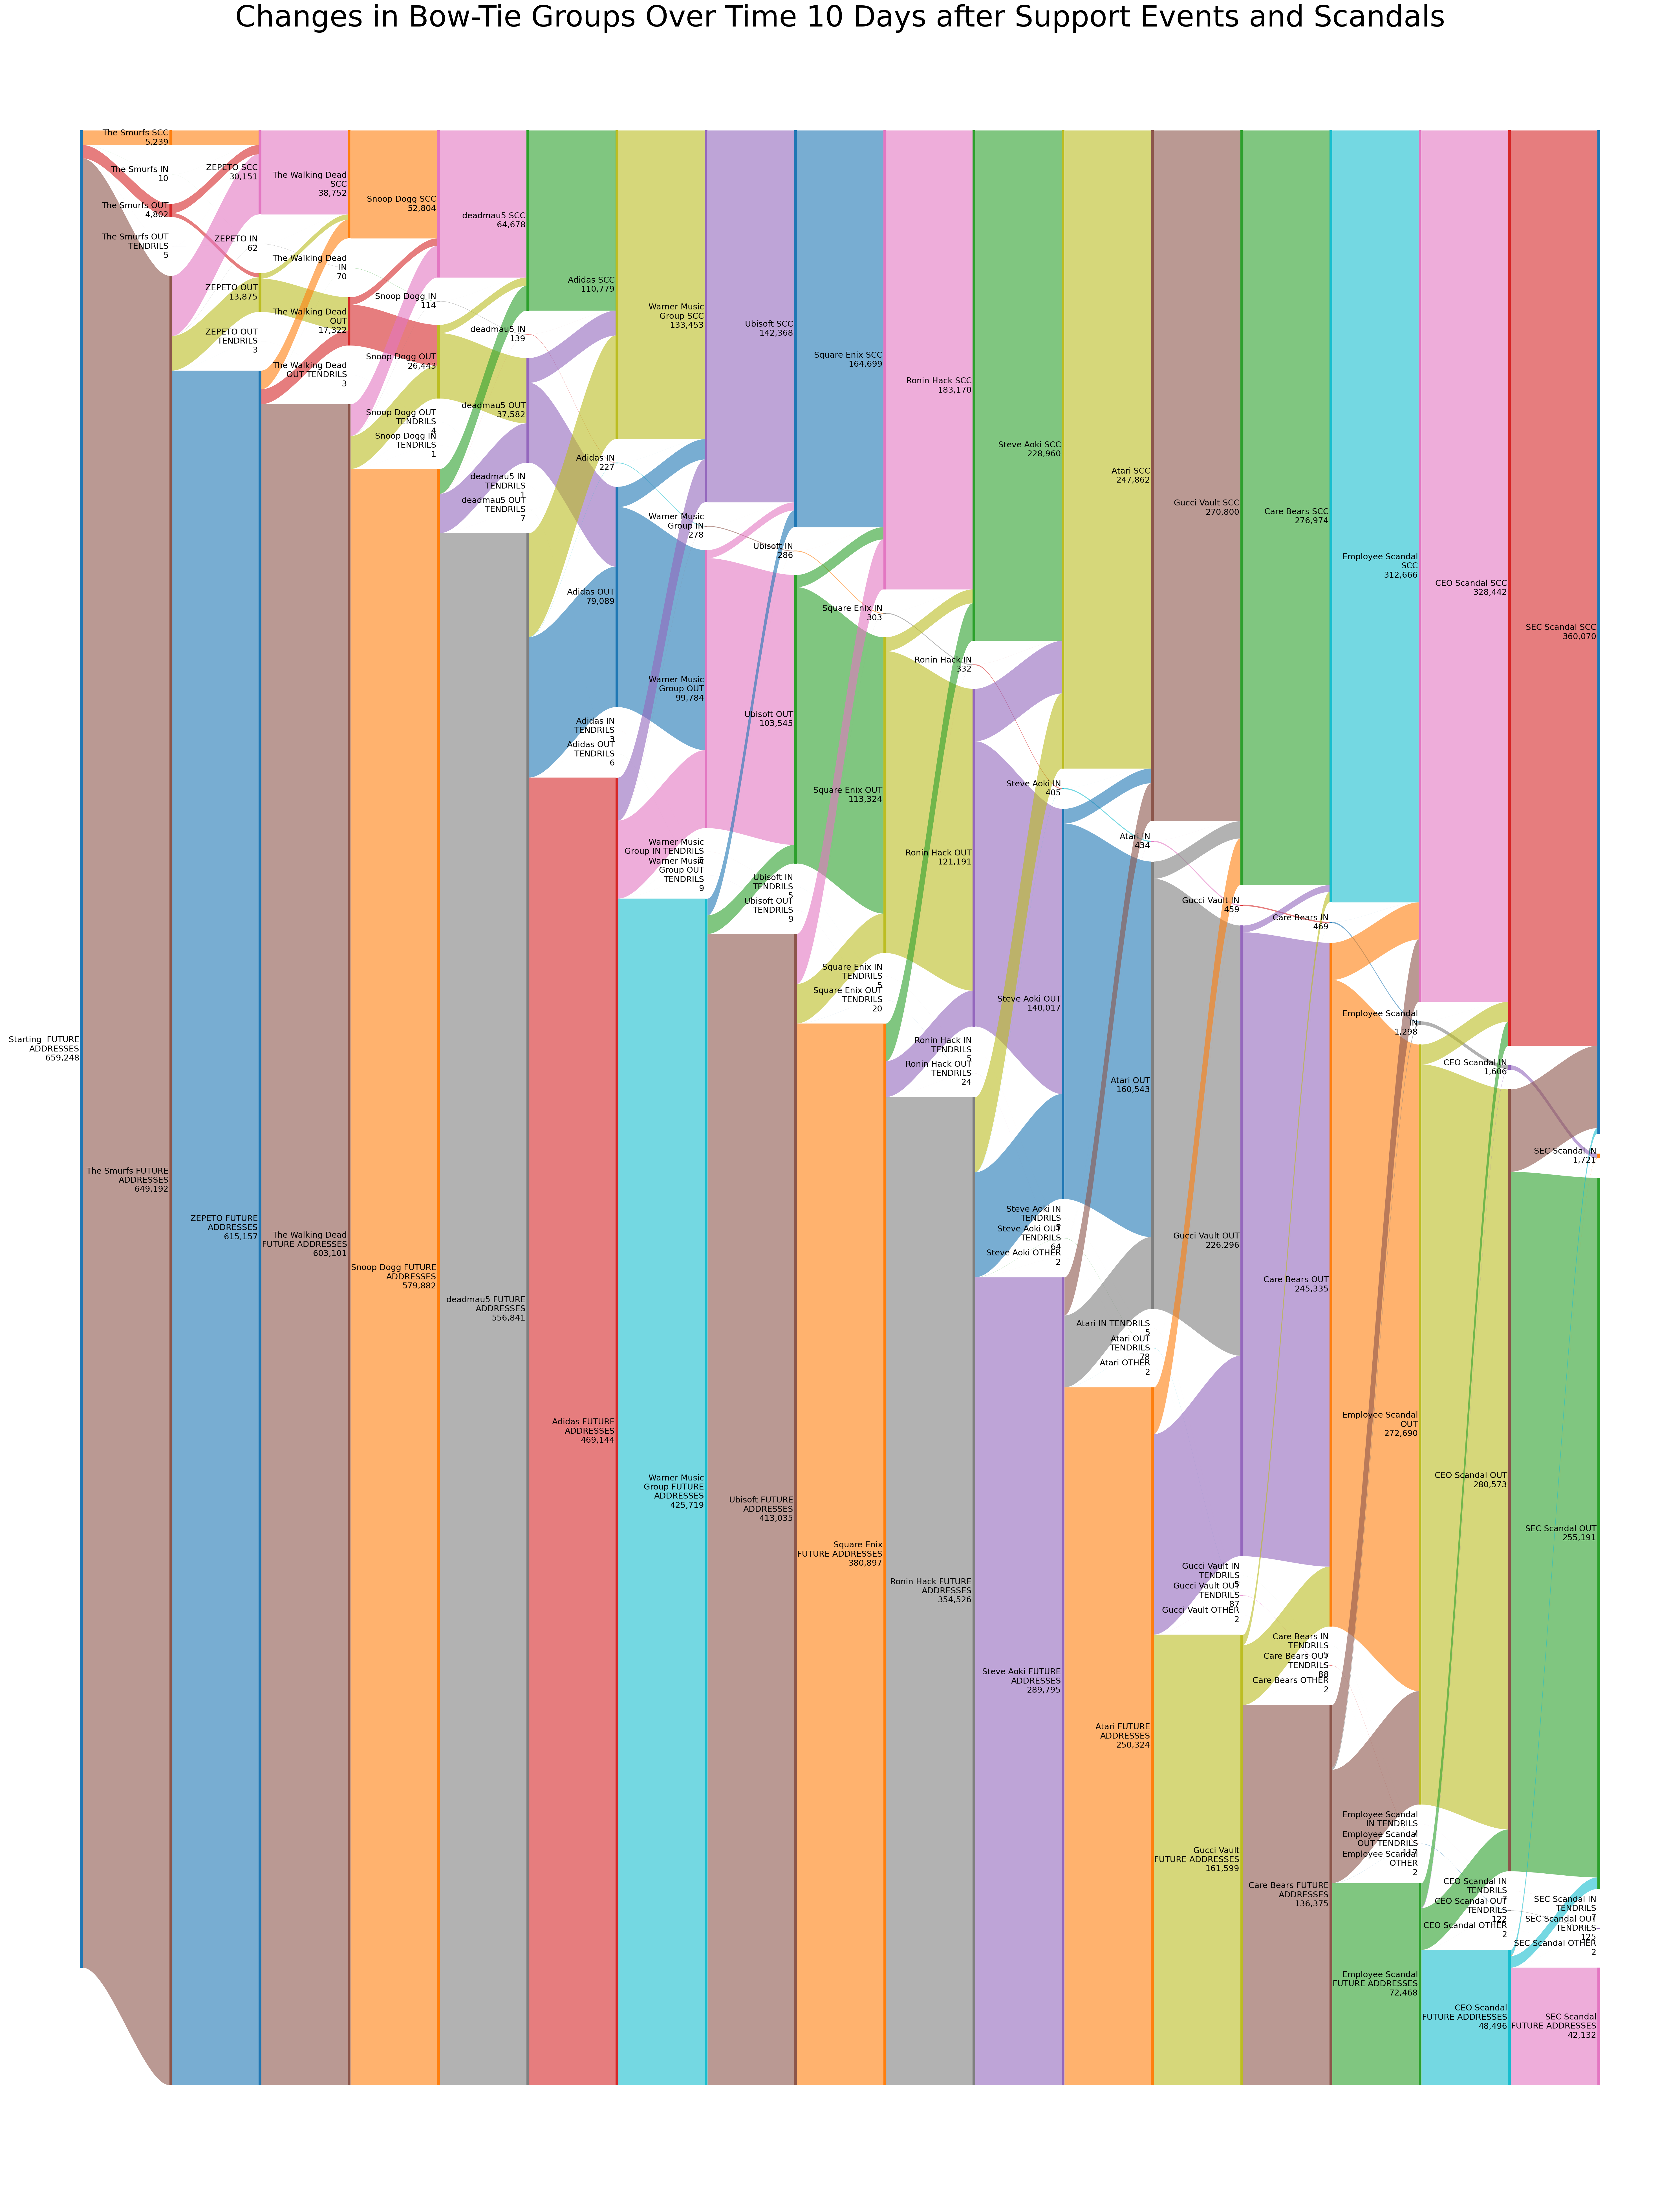

In [188]:
plt.figure(figsize=(8.5 * 6, 11 * 6), dpi=150)

s = Sankey(flows=flowData, flow_color_mode="lesser")
s.draw()
plt.title("Changes in Bow-Tie Groups Over Time 10 Days after Support Events and Scandals", fontsize=50)
plt.savefig(
    fname=graphFolder
    + "sankey/"
    + "Changes in Bow-Tie Groups over time due to Events"
    + graphFileType,
    bbox_inches="tight",
)
plt.show()
